In [1]:
!pip install torch transformers datasets nltk pandas matplotlib seaborn plotly scikit-learn evaluate rouge-score

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BertTokenizer, T5Tokenizer, GPT2Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
from concurrent.futures import ProcessPoolExecutor

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")
df = pd.DataFrame(dataset['train'])

print(df.info())
print(df.head())
print(df.info())
print(df.describe())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB
None
                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  
<class 'pandas.core.frame.

In [4]:
# Drop any irrelevant columns (if any)
df = df[['question', 'answer']]

# Drop rows with missing values
df.dropna(inplace=True)

# Display cleaned data
print(df.head())

print(df.info())

                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB
None


In [5]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Define the split sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Split the data
train_df, temp_df = train_test_split(df, test_size=(1 - train_size), random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=(test_size / (test_size + val_size)), random_state=42)

# Check the sizes of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_dict = {
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
}

# Convert to DatasetDict
final_dataset = DatasetDict(dataset_dict)

# Check the splits
print(final_dataset)

Training set size: 45121
Validation set size: 5640
Test set size: 5641
DatasetDict({
    train: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 45121
    })
    validation: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 5640
    })
    test: Dataset({
        features: ['question', 'answer', '__index_level_0__'],
        num_rows: 5641
    })
})


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

train_df['question'] = train_df['question'].apply(preprocess_text)
train_df['answer'] = train_df['answer'].apply(preprocess_text)
val_df['question'] = val_df['question'].apply(preprocess_text)
val_df['answer'] = val_df['answer'].apply(preprocess_text)
test_df['question'] = test_df['question'].apply(preprocess_text)
test_df['answer'] = test_df['answer'].apply(preprocess_text)

# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_dict = {
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
}

# Convert to DatasetDict
final_dataset = DatasetDict(dataset_dict)

def tokenize(example):
    return tokenizer(example['question'], example['answer'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = final_dataset.map(tokenize, batched=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/5640 [00:00<?, ? examples/s]

Map:   0%|          | 0/5641 [00:00<?, ? examples/s]

In [7]:
from torch.utils.data import Dataset

class QADataset:
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        question = item['question']
        answer = item['answer']

        # Tokenize question and answer
        encoding = self.tokenizer(question, answer, return_tensors='pt', max_length=128, padding='max_length', truncation=True)

        # Calculate start and end positions
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        answer_ids = self.tokenizer(answer, return_tensors='pt', max_length=128, padding='max_length', truncation=True)['input_ids'].squeeze()
        start_positions = (input_ids == answer_ids[0]).nonzero(as_tuple=True)
        if len(start_positions[0]) == 0:
            start_positions = 0
            end_positions = 0
        else:
            start_positions = start_positions[0][0].item()
            end_positions = start_positions + len(answer_ids) - 1

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': int(start_positions),
            'end_positions': int(end_positions)
        }

train_dataset = QADataset(tokenized_datasets['train'], tokenizer)
val_dataset = QADataset(tokenized_datasets['validation'], tokenizer)
test_dataset = QADataset(tokenized_datasets['test'], tokenizer)



In [31]:
from transformers import BertForQuestionAnswering, Trainer, TrainingArguments


def fine_tune_model(model, train_dataset, eval_dataset, model_name):
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=48,  # Reduced batch size
        per_device_eval_batch_size=48,  # Reduced batch size
        num_train_epochs=8,  # Single epoch to fit within Colab's free resources
        weight_decay=0.01,
        save_steps=10_000,
        save_total_limit=2,
        logging_dir='./logs',
        logging_steps=10,
        fp16=True,  # Use mixed precision training if supported
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        # compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
bert_trainer = fine_tune_model(model, train_dataset, val_dataset, 'bert')


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000100,0.000036
2,0.000000,0.000016
3,0.000000,0.000010
4,0.000000,0.000008
5,0.000000,0.000006
6,0.000000,0.000005
7,0.000000,0.000004


Epoch,Training Loss,Validation Loss
1,0.000100,0.000036
2,0.000000,0.000016
3,0.000000,0.000010
4,0.000000,0.000008
5,0.000000,0.000006
6,0.000000,0.000005
7,0.000000,0.000004
8,0.000000,0.000004


In [32]:
model.save_pretrained(f'./results/bert')
tokenizer.save_pretrained(f'./results/bert')

('./results/bert/tokenizer_config.json',
 './results/bert/special_tokens_map.json',
 './results/bert/vocab.txt',
 './results/bert/added_tokens.json',
 './results/bert/tokenizer.json')

In [37]:
from transformers import pipeline
from datasets import load_metric

# Load the fine-tuned model and tokenizer
model = BertForQuestionAnswering.from_pretrained('./results/bert')
tokenizer = AutoTokenizer.from_pretrained('./results/bert')

# Specify the device as 0 to use GPU
qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer, device=0)

# Load the metrics
rouge = load_metric("rouge")
bleu = load_metric("bleu")
meteor = load_metric("meteor")

import time
from nltk.tokenize import word_tokenize

# Function to calculate metrics
def compute_metrics(predictions, references):
    tokenized_predictions = [word_tokenize(pred) for pred in predictions]
    tokenized_references = [[word_tokenize(ref)] for ref in references]  # BLEU expects a list of lists

    rouge_score = rouge.compute(predictions=predictions, references=references, rouge_types=["rouge1", "rouge2", "rougeL"])
    bleu_score = bleu.compute(predictions=tokenized_predictions, references=tokenized_references)
    meteor_score = meteor.compute(predictions=predictions, references=references)
    return rouge_score, bleu_score, meteor_score

# Reduce the size of the test dataset for quicker testing
# Assuming each question-answer pair is used for context-answering
test_questions = test_df['question'].tolist()[:100]  # Use only the first 100 samples
test_answers = test_df['answer'].tolist()[:100]      # Use only the first 100 samples

predictions = []
references = []

start_time = time.time()

# Create a list of dictionaries for the dataset usage in pipeline
qa_inputs = [{"question": question, "context": answer} for question, answer in zip(test_questions, test_answers)]

# Use the pipeline with the dataset for efficiency
results = qa_pipeline(qa_inputs)

for i, result in enumerate(results):
    predictions.append(result['answer'])
    references.append(test_answers[i])

    if i % 10 == 0:  # Print every 10 iterations
        print(f"Processed {i} samples, time elapsed: {time.time() - start_time:.2f} seconds")

# Compute metrics
rouge_score, bleu_score, meteor_score = compute_metrics(predictions, references)

print(f"ROUGE Score: {rouge_score}")
print(f"BLEU Score: {bleu_score}")
print(f"METEOR Score: {meteor_score}")
print(f"Total time elapsed: {time.time() - start_time:.2f} seconds")

# Convert the metrics into a DataFrame and display in tabular format
metrics_data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR'],
    'Precision': [
        rouge_score['rouge1'].mid.precision,
        rouge_score['rouge2'].mid.precision,
        rouge_score['rougeL'].mid.precision,
        bleu_score['precisions'][0],  # BLEU score's precision
        'N/A'  # METEOR doesn't have precision
    ],
    'Recall': [
        rouge_score['rouge1'].mid.recall,
        rouge_score['rouge2'].mid.recall,
        rouge_score['rougeL'].mid.recall,
        'N/A',  # BLEU doesn't have recall
        'N/A'  # METEOR doesn't have recall
    ],
    'F-Measure': [
        rouge_score['rouge1'].mid.fmeasure,
        rouge_score['rouge2'].mid.fmeasure,
        rouge_score['rougeL'].mid.fmeasure,
        bleu_score['bleu'],  # BLEU score itself
        meteor_score['meteor']  # METEOR score itself
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Processed 0 samples, time elapsed: 2.52 seconds
Processed 10 samples, time elapsed: 2.52 seconds
Processed 20 samples, time elapsed: 2.52 seconds
Processed 30 samples, time elapsed: 2.52 seconds
Processed 40 samples, time elapsed: 2.52 seconds
Processed 50 samples, time elapsed: 2.52 seconds
Processed 60 samples, time elapsed: 2.52 seconds
Processed 70 samples, time elapsed: 2.52 seconds
Processed 80 samples, time elapsed: 2.52 seconds
Processed 90 samples, time elapsed: 2.52 seconds
ROUGE Score: {'rouge1': AggregateScore(low=Score(precision=0.49, recall=0.04418117365870114, fmeasure=0.07268101325548129), mid=Score(precision=0.59, recall=0.07244662472878502, fmeasure=0.10599293888798715), high=Score(precision=0.69, recall=0.10670233896575994, fmeasure=0.14644417842312688)), 'rouge2': AggregateScore(low=Score(precision=0.2, recall=0.014851402416057945, fmeasure=0.024782192910122493), mid=Score(precision=0.29, recall=0.032493629193060265, fmeasure=0.048036463491864106), high=Score(precis

+----+----------+------------+
|    | Metric   |      Score |
+====+==========+============+
|  0 | ROUGE-1  | 0.105993   |
+----+----------+------------+
|  1 | ROUGE-2  | 0.0480365  |
+----+----------+------------+
|  2 | ROUGE-L  | 0.10588    |
+----+----------+------------+
|  3 | BLEU     | 8.2094e-20 |
+----+----------+------------+
|  4 | METEOR   | 0.080459   |
+----+----------+------------+


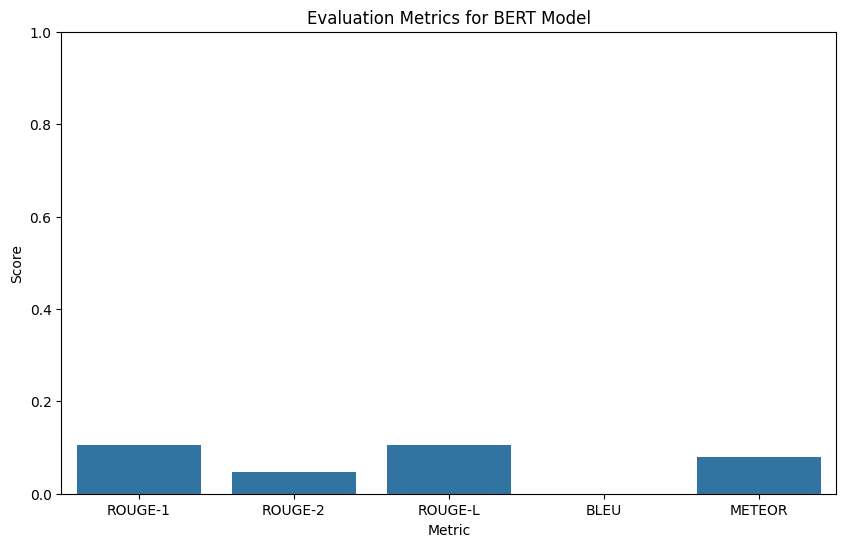

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate

# Prepare data for visualization
metrics_data = {
    'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR'],
    'Score': [
        rouge_score['rouge1'].mid.fmeasure,
        rouge_score['rouge2'].mid.fmeasure,
        rouge_score['rougeL'].mid.fmeasure,
        bleu_score['bleu'],
        meteor_score['meteor']
    ]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the metrics in a tabular format
print(tabulate(metrics_df, headers='keys', tablefmt='grid'))

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Evaluation Metrics for BERT Model')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming the metrics are in the range [0, 1]
plt.show()
